# Fashion MNIST CNN

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import to_categorical
from tensorflow.keras import backend as K

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tqdm import tqdm

print(tf.__version__)

2.16.1


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

K.clear_session()

In [3]:
# PARAMS:
SCALING_FACTOR = 2
AUGMENTATION = True
WHITENING = False
N_EPOCHS = 500
IMAGE_SIZE = (28, 28)
BUFFER_SIZE = 10_000
BATCH_SIZE = 1024
PATIENCE = 20

## Import the Dataset

In [4]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [5]:
train_labels_encoded = to_categorical(train_labels, 10)
test_labels_encoded = to_categorical(test_labels, 10)

In [6]:
def example_images(images, labels, class_names, num_images=10):
    samples = {}
    
    # Shuffle the indices to ensure randomness
    indices = np.arange(len(labels))
    np.random.shuffle(indices)
    
    # Collect one random sample image for each class
    for i in indices:
        label = np.argmax(labels[i])
        if label not in samples:
            samples[label] = images[i]
        if len(samples) == num_images:  # We need one of each class
            break

    # Plot the collected images
    plt.figure(figsize=(15, 5))
    for i, (label, img) in enumerate(samples.items()):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(img.reshape(IMAGE_SIZE[0], IMAGE_SIZE[1]), cmap='gray')
        plt.title(class_names[label])
        plt.axis('off')
    plt.show()

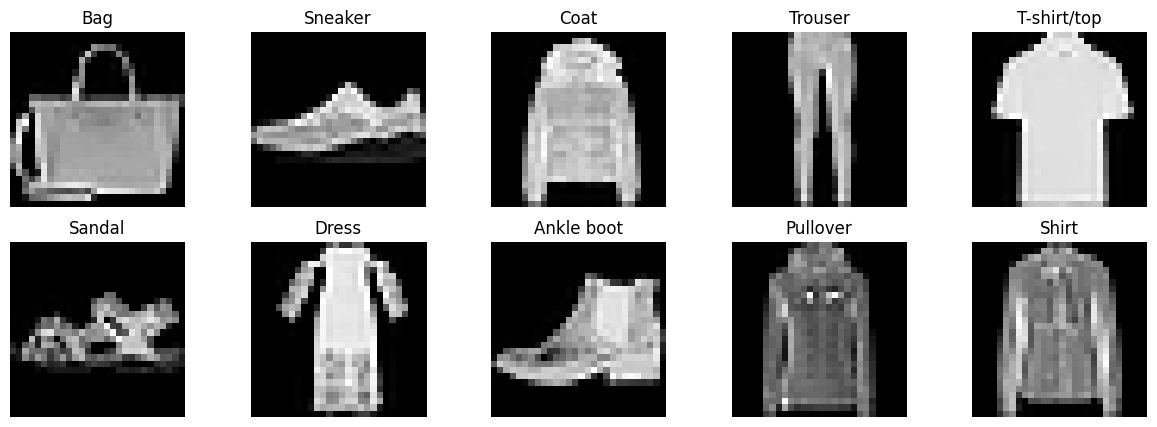

In [7]:
example_images(train_images, train_labels_encoded, class_names)

# Preprocessing

Aplicaremos aumentación de datos y Whitening

In [8]:
# Normalize pixel values to the range [0, 1]
train_images_scaled = train_images.astype('float32') / 255.0
test_images_scaled = test_images.astype('float32') / 255.0

if SCALING_FACTOR > 0:
    upscaled_images = np.repeat(train_images_scaled.copy(), SCALING_FACTOR + 1, axis=0)
    upscaled_labels = np.repeat(train_labels_encoded.copy(), SCALING_FACTOR + 1, axis=0)
else:
    upscaled_images = train_images_scaled
    upscaled_labels = train_labels_encoded

print("Data Upscaling applied to train datasets.")

Data Upscaling applied to train datasets.


In [9]:
temp_train_dataset = tf.data.Dataset.from_tensor_slices((upscaled_images, upscaled_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images_scaled, test_labels_encoded))

In [10]:
validation_split = 0.2
train_size = int((1 - validation_split) * len(upscaled_images))

# Shuffle the dataset (optional but recommended for a more random split)
temp_train_dataset = temp_train_dataset.shuffle(buffer_size = BUFFER_SIZE)

# Split the dataset
train_dataset = temp_train_dataset.take(train_size)
validation_dataset = temp_train_dataset.skip(train_size)

# Batch the datasets (adjust the batch size as needed)
train_dataset = train_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [11]:
print(len(train_dataset))
print(len(validation_dataset))
print(len(test_dataset))

141
36
10


# CNN Model

In [12]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(0.2),
])

In [13]:
cnn_model = tf.keras.Sequential([
    layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[0], 1)),
    
    data_augmentation,

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dropout(0.5),  # Add dropout here
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dense(10, activation='softmax')
])

In [14]:
cnn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.F1Score(average='weighted'),'accuracy'],
)

cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 486,282 (1.86 MB)

 Trainable params: 485,898 (1.85 MB)

 Non-trainable params: 384 (1.50 KB)

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience = PATIENCE,
    restore_best_weights=True
)

history = cnn_model.fit(
    train_dataset,
    epochs = N_EPOCHS,
    callbacks = [early_stopping],
    validation_data = validation_dataset
)

Epoch 1/500
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.6645 - f1_score: 0.6622 - loss: 1.2951 - val_accuracy: 0.1560 - val_f1_score: 0.0937 - val_loss: 4.1865
Epoch 2/500
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.8303 - f1_score: 0.8287 - loss: 0.6607 - val_accuracy: 0.2141 - val_f1_score: 0.1512 - val_loss: 4.3766
Epoch 3/500
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.8566 - f1_score: 0.8556 - loss: 0.5443 - val_accuracy: 0.3934 - val_f1_score: 0.3594 - val_loss: 2.0934
Epoch 4/500
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.8709 - f1_score: 0.8701 - loss: 0.4739 - val_accuracy: 0.6996 - val_f1_score: 0.7002 - val_loss: 0.9055
Epoch 5/500
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.8800 - f1_score: 0.8794 - loss: 0.4255 - val_accuracy: 0.8499 - val_f1_score: 0.8499 - val_loss: 0.4657
Epoch 6/500
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.8851 - f1_score: 0.8846 - loss: 0.3981 - val_accuracy: 0.8729 - val_f1_

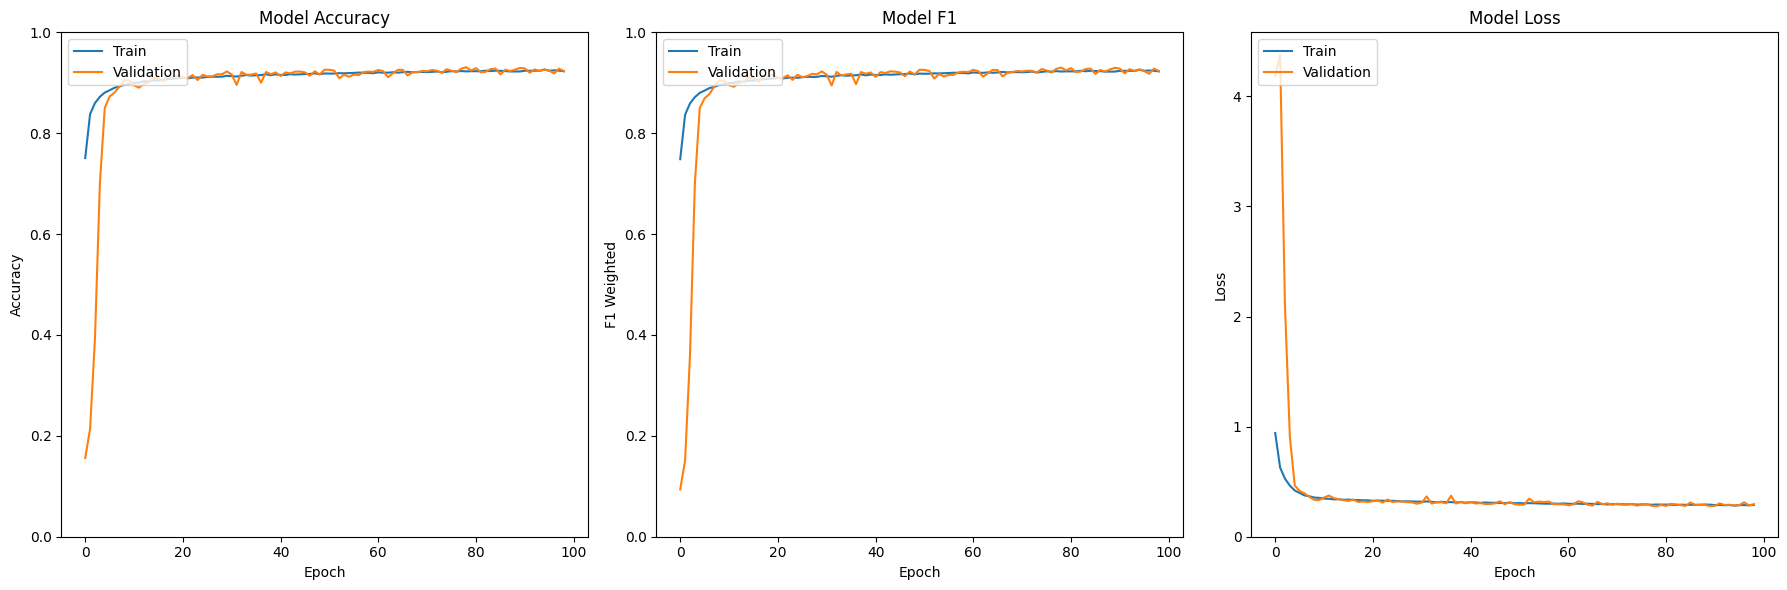

In [16]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')
ax1.set_ylim([0,1])

# Plot training & validation accuracy values
ax2.plot(history.history['f1_score'])
ax2.plot(history.history['val_f1_score'])
ax2.set_title('Model F1')
ax2.set_ylabel('F1 Weighted')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
ax2.set_ylim([0,1])

# Plot training & validation loss values
ax3.plot(history.history['loss'])
ax3.plot(history.history['val_loss'])
ax3.set_title('Model Loss')
ax3.set_ylabel('Loss')
ax3.set_xlabel('Epoch')
ax3.legend(['Train', 'Validation'], loc='upper left')
ax3.set_ylim(bottom=0)

# Show the plots
plt.tight_layout()
plt.show()

In [17]:
# cnn_model.save('cnn_classifier.keras')

# Performance

In [18]:
train_loss, train_f1, train_accuracy = cnn_model.evaluate(train_dataset)
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_accuracy}")
print(f"Train F1 by Class: {train_f1}")

141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9432 - f1_score: 0.9426 - loss: 0.2351
Train Loss: 0.23272249102592468
Train Accuracy: 0.9446735978126526
Train F1 by Class: 0.9440993666648865


In [19]:
val_loss, val_f1, val_accuracy = cnn_model.evaluate(validation_dataset)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation F1 by Class: {val_f1}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9338 - f1_score: 0.9333 - loss: 0.2673
Validation Loss: 0.27500373125076294
Validation Accuracy: 0.9315277934074402
Validation F1 by Class: 0.9309301376342773


In [20]:
test_loss, test_f1, test_accuracy = cnn_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test F1 by Class: {test_f1}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9196 - f1_score: 0.9188 - loss: 0.3075
Test Loss: 0.3022027313709259
Test Accuracy: 0.9204999804496765
Test F1 by Class: 0.919632077217102


In [21]:
results = {
    'Train' : [train_loss, train_accuracy, train_f1],
    'Validation' : [val_loss, val_accuracy, val_f1],
    'Test' : [test_loss, test_accuracy, test_f1],
}

pd.DataFrame(results, index = ['Loss', 'Accuracy', 'F1'])

,Train,Validation,Test
Loss,0.232722,0.275004,0.302203
Accuracy,0.944674,0.931528,0.920500
F1,0.944099,0.930930,0.919632
